In [1]:
import sys, os
import numpy as np

from scipy.optimize import minimize_scalar, newton
from scipy.integrate import quad
import scipy.signal as sig
from scipy.special import erf

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

*Note.* For concreteness, we calculate the differential rate $dR/dq$ for a fixed DM mass, coupling, and mediator mass.

## Parameters

In [2]:
hbarc = 0.2     # eV um
rho_T = 2.0e3   # Sphere density, kg/m^3
mAMU = 1.66e-27 # Neutron mass

### Experiment parameters

In [3]:
R_um = 5          # Sphere radius, um
R = R_um / hbarc  # Radius in natural units, eV^-1

N_T = 0.5 * ( 4/3 * np.pi * (R_um*1e-6)**3) * rho_T/mAMU # Number of neutrons
res = 170e6       # detector resolution in eV

q_thr = 0.05e9    # momentum threshold, eV

### DM parameters

In [4]:
M_X_in = 5e3         # GeV
alpha_n_in = 1e-8    # Gev
m_phi = 0.0001       # Mediator mass, eV

In [5]:
M_X = M_X_in * 1e9   # Dark matter nugget mass, eV (assumes mass in GeV given on command line)
m_chi = 0.01 * 1e9   # eV
N_chi = M_X / m_chi  # Number of dark matter particles in the nugget

rhoDM = 0.3e9        # dark matter mass density, eV/cm^3

alpha_n = alpha_n_in # Dimensionless single neutron-nugget coupling
alpha = alpha_n * N_T # Coupling of the entire sphere
mR = m_phi * R        # (= R/lambda), a useful length scale; now defiend in `vtot()`

Some parameters related to DM velocity distribution.

In [6]:
vmin = 5e-5      # minimum velocity to consider, natural units (c)
vesc = 1.815e-3  # galactic escape velocity
v0 = 7.34e-4     # v0 parameter from Zurek group paper
ve = 8.172e-4    # ve parameter from Zurek group paper

## Defining functions

### Yukawa potential

In [7]:
def vtot_func(u, m_phi=m_phi, alpha=alpha):
    """Exact Yukawa potential for a uniform density sphere
    
    Parameters
    ----------
    u : float
        Distance inverse 1/r in eV
    m_phi : float
        Mediator mass in eV
    alpha : float
        Dimensionless DM coupling to the sphere
        
    Returns
    -------
    float
        Potential V(u) in eV
    """
    mR = m_phi * R
    
    # Devide the array of u=1/r into three cases
    if (u < 1e-10) : return np.inf
    
    if (u < 1/R):  # outside
        return 3 * alpha/mR**3 * (mR * np.cosh(mR) - np.sinh(mR)) * np.exp(-m_phi/u) * u
    
    else:          # inside
        return 3 * alpha/mR**3 * (m_phi - u*(1 + mR)/(1+1./np.tanh(mR)) * (np.sinh(m_phi/u)/np.sinh(mR)))

In [8]:
def vtot(u, m_phi=m_phi, alpha=alpha):
    """Exact Yukawa potential for a uniform density sphere
    
    Parameters
    ----------
    u : float, array-like
        Distance inverse 1/r in eV
    m_phi : float
        Mediator mass in eV
    alpha : float
        Dimensionless DM coupling to the sphere
        
    Returns
    -------
    float, array-like
        Potential V(u) for each u in eV
    """
    mR = m_phi * R
    
    u = np.asarray(u)
    ret = np.empty_like(u)
    
    # Devide the array of u=1/r into three cases
    neg     = (u <= 0)   # ill-defined
    outside = (u < 1/R)  # ouside sphere
    inside  = (u >= 1/R) # inside sphere
    
    ret[neg] = np.inf
    
    if(mR > 0):   # massive mediator
        ret[outside] = 3 * alpha/mR**3 * (mR * np.cosh(mR) - np.sinh(mR)) * np.exp(-m_phi/u[outside]) * u[outside]
        ret[inside] = 3 * alpha/mR**3 * (m_phi - u[inside]*(1 + mR)/(1+1./np.tanh(mR)) * (np.sinh(m_phi/u[inside])/np.sinh(mR)))
        
    else:         # massless mediator (alpha/r)
        ret[outside] = alpha * u[outside]
        ret[inside] = alpha/2 * (3/R - 1./(R**3 * u[inside]**2))

    return ret

Text(0, 0.5, 'v(r)')

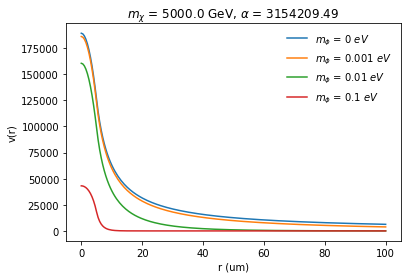

In [9]:
# Plotting the potential
r_um = np.linspace(1e-8, 100, 200)
r = r_um / hbarc # convert to eV

plt.plot(r_um, vtot(1/r, m_phi=0), label='$m_\phi$ = 0 $eV$')
plt.plot(r_um, vtot(1/r, m_phi=0.001), label='$m_\phi$ = 0.001 $eV$')
plt.plot(r_um, vtot(1/r, m_phi=0.01), label='$m_\phi$ = 0.01 $eV$')
plt.plot(r_um, vtot(1/r, m_phi=0.1), label='$m_\phi$ = 0.1 $eV$')

plt.title(fr'$m_\chi$ = {M_X_in} GeV, $\alpha$ = {alpha:.2f}')
plt.legend(frameon=False)
plt.xlabel('r (um)')
plt.ylabel('v(r)')

### Other functions (not organized yet)

In [59]:
def get_color_map(n):
    jet = plt.get_cmap('jet') 
    cNorm  = colors.Normalize(vmin=0, vmax=n-1)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    outmap = []
    for i in range(n):
        outmap.append( scalarMap.to_rgba(i) )
    return outmap

## function used to smear the spectrum with gaussian resolution
def res_fun( x, sig ):
    return 1.0/(sig * np.sqrt(2*np.pi)) * np.exp(-0.5*(x/sig)**2)

## Calculate the differential cross section $\frac{d\sigma}{dq}$

We calculate the cross section for a single dark matter velocity $v$, and then integrate over the dark matter velocity distribution later.

In [13]:
nvels = 2000      # number of velocities to include in integration
vlist = np.linspace(vmin, vesc, nvels)

pmax = np.max((vesc * M_X, 10e9))
#cmap = get_color_map(nvels)

In [14]:
v = vlist[0]

Make a list of impact parameters over which to calculate the scattering angle

In [15]:
if(m_phi > 0):
    b_um = np.logspace(-3, 3, 2000)
else:
    b_um = np.logspace(-3, 5, 2000)

In [39]:
p = M_X * v            # DM initial momentum (eV)
E = 1./2 * M_X * v**2  # Initial kinetic energy of incoming particle

b = b_um / hbarc       # Impact factor (eV^-1)

### Shortest distance

Calculate the distance of shortest approach (maximum $u$) for each impact parameter $b$. This would be the upper limit when integrating over $u$ to get the scattering angle for each $b$.

Maximum $u$ can be found by solving the equation
$$
    1 - b^2 u^2_\text{max} - \frac{V(u_\text{max})}{E_\text{cm}} = 0.
$$

There is an analytic formula in Dave's code but it's unclear to me whether it's correct. It seems like it's the first-order "perturbative" solution assuming $r = 1/u \approx b$.

In [17]:
def max_u_analytic(E, b, m_phi=m_phi, alpha=alpha):
    """Maximum u (minimum r) during the scattering from analytic formua
    
    Parameters
    ----------
    E : float, array-like
        CM energy in eV
    b : float, array-like
        Impact parameter in eV^-1
        
    Returns
    -------
    m * n array
        Max u value. m = dim(E), n = dim(b)
    """
    mR = m_phi * R
    
    E, b = np.asarray(E), np.asarray(b)
    EE, bb = np.meshgrid(E, b)
    
    min_r = np.empty_like(EE)
    
    inside  = (bb < R)
    outside = (bb >= R)
    
    # TODO
    # It seems like the formula breaks down when E is relatively small
    if mR > 0:  # massive mediator
        min_r[inside]  = bb[inside] * np.sqrt(EE[inside]) / np.sqrt(EE[inside] - ((3*alpha)/(mR**3)*(m_phi - ((1 + mR)*np.sinh(m_phi*bb[inside])/np.sinh(mR))/(bb[inside]*(1+1/np.tanh(mR))))))
        min_r[outside] = bb[outside] * np.sqrt(EE[outside]) / np.sqrt(EE[outside] - (3*alpha*np.exp(-m_phi*bb[outside]))/(bb[outside] * mR**3) * (mR*np.cosh(mR)-np.sinh(mR)))
    else:       # massless mediator TODO
        pass
    
    return 1. / min_r

Alternatively, we can numerically solve the equation:

In [18]:
def max_u_func(u, b, E):
    return 1 - (b*u)**2 - vtot(u) / E

def max_u_numerical(E, b, m_phi=m_phi, alpha=alpha):    
    """Numerical solution of maximum u during the scattering
    
    Parameters
    ----------
    E : float
        CM energy in eV
    b : float, array-like
        Impact parameter in eV^-1
        
    Returns
    -------
    1 * n array
        Max u value. n = dim(b)
    """
    max_u = newton(max_u_func, x0=b, args=(b,E))
    return max_u

Comparing the two approches, they differ when $b$ is small. It makes sense to me to use the numerical solution.

C:\Users\yuhan\AppData\Local\Temp\ipykernel_17780\1436004733.py:29: RuntimeWarning: invalid value encountered in sqrt
  min_r[inside]  = bb[inside] * np.sqrt(EE[inside]) / np.sqrt(EE[inside] - ((3*alpha)/(mR**3)*(m_phi - ((1 + mR)*np.sinh(m_phi*bb[inside])/np.sinh(mR))/(bb[inside]*(1+1/np.tanh(mR))))))
C:\Users\yuhan\AppData\Local\Temp\ipykernel_17780\1436004733.py:30: RuntimeWarning: invalid value encountered in sqrt
  min_r[outside] = bb[outside] * np.sqrt(EE[outside]) / np.sqrt(EE[outside] - (3*alpha*np.exp(-m_phi*bb[outside]))/(bb[outside] * mR**3) * (mR*np.cosh(mR)-np.sinh(mR)))


Text(0, 0.5, 'Max u (um)')

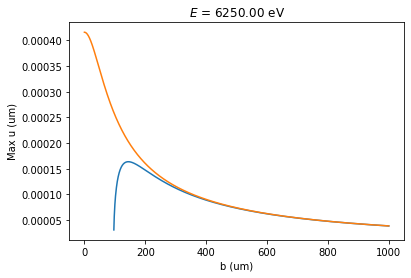

In [19]:
plt.plot(b*hbarc, max_u_analytic(E, b)*hbarc)
plt.plot(b*hbarc, max_u_numerical(E, b)*hbarc)

plt.title(fr'$E$ = {E:.2f} eV')
plt.xlabel('b (um)')
plt.ylabel('Max u (um)')

In [20]:
max_u = max_u_numerical(E, b)

### Integrate for scattering angle

To calculate the scattering angle $\Theta$ as a function of DM energy $E$ and impact parameter $b$, we will use the following formula
$$
\begin{aligned}
    \Psi(b) &= \int_{r_\text{min}}^\infty \frac{(b/r^2) dr}{\sqrt{(1 - V(r)/E_\text{cm} - b^2/r^2)}} \\
              &= \int_0^{u_\text{max}} \frac{b du}{\sqrt{(1 - V(u)/E_\text{cm} - b^2u^2)}},
\end{aligned}
$$
where $\Psi$ is the change of angle when moving through the central force field and $E_\text{cm}$ is the total energy in the CM frame (equals to DM kinetic energy).

The scattering angle is
$$
    \Theta(b) = \pi - 2 \cdot \Psi(b).
$$
This is actually the scattering angle in the CM frame, but we assume the sphere is very heavy so it's the same as $\theta$, the scattering angle in the lab frame.

In [21]:
from scipy.integrate import quad_vec

def integrand(u, E, _b):
    """
    Integrand for scattering angle calculation
    
    Parameters
    ----------
    u : float
    E : float
        CM energy in eV
    _b : float
        Impact parameter in eV^-1
        
    Returns
    -------
    float
        Max u value.
    
    """    
    sval = 1 - vtot_func(u)/E - (_b*u)**2
    if sval < 1e-10:  # cut off bad values that should be zero
        sval= np.inf

    integ = _b / np.sqrt(sval)
    return integ

Check the behavior of the integrand (the integrand seems to hit numerical issues when approaching umax)

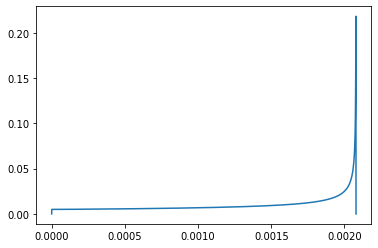

In [22]:
idx = [0]
for i in idx:
    _b = b[i]
    umax = max_u[i]
    
    ulist = np.linspace(0, umax, 2000)
    integ = np.empty_like(ulist)
    for i, u in enumerate(ulist):
        integ[i] = integrand(u, E, _b)
    plt.plot(ulist, integ)

In [31]:
Psi = np.empty_like(b)
for i, _b in enumerate(b):
    umax = max_u[i]
    _b = b[i]
    Psi[i] = quad(integrand, 0, umax, args=(E, _b))[0]

In [32]:
theta = np.pi - 2 * Psi

Text(0, 0.5, '$\\theta(b)$')

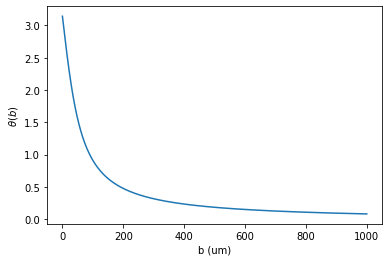

In [34]:
plt.plot(b*hbarc, theta)
plt.xlabel('b (um)')
plt.ylabel(r'$\theta(b)$')

Check the result with Dave's code

In [56]:
bvec = b
Psi_dave = np.empty_like(b)

def vtot_dave(u):
    if(u <= 0):
        return np.inf
    elif(u < 1/R):
        if(mR > 0):
            return 3*alpha/mR**3 * (mR * np.cosh(mR) - np.sinh(mR)) * np.exp(-m_phi/u) * u
        else:
            return alpha * u
    else:
        if(mR > 0):
            return 3*alpha/mR**3 * (m_phi - u*(1 + mR)/(1+1./np.tanh(mR)) * (np.sinh(m_phi/u)/np.sinh(mR)))
        else:
            return alpha/2 * (3/R - 1./(R**3 * u**2)) 
        
## integrand needed for finding the scattering angle as a function of impact parameter
def integ(u, b, E):
    sval = 1 - vtot_dave(u)/E - (b*u)**2
    #print(u,b,E,vtot(u)/E, b*u, sval)
    if(sval >= 0):
        integ = b/np.sqrt(sval)
    else:
        integ = 0
    return integ

def integ_out(u, b, E):
    if(u <= 0):
        sval = 0
    else:
        if(mR > 0):
            sval = 3*alpha/mR**3 * (mR * np.cosh(mR) - np.sinh(mR)) * np.exp(-m_phi/u) * u
        else:
            sval = alpha * u
    return b/np.sqrt(1 - sval/E - (b*u)**2)

def integ_in(u, b, E):
    if(u <= 0):
        sval = 0
    else:
        if(mR > 0):
            sval = 3*alpha/mR**3 * (m_phi - u*(1 + mR)/(1+1./np.tanh(mR)) * (np.sinh(m_phi/u)/np.sinh(mR)))
        else:
            sval = alpha/2 * (3/R - 1./(R**3 * u**2))
    return b/np.sqrt(1 - sval/E - (b*u)**2)

def minr_func(u,b,E):
        return np.abs( 1 - (b*u)**2 - vtot(u)/E)

for i, b in enumerate(bvec):
    
    min_un = minimize_scalar(minr_func, args=(b,E),bounds=(hbarc/1e3,hbarc/1e-3),method='bounded',options={'disp': 0, 'xatol': 1e-15})
    min_u = min_un.x

    ## split the integral into two pieces, to handle the diverging piece only over a small range
    ## this substantially improves the performance of quad
    int_res1 = quad(integ, min_u/1e7, min_u*0.9, args=(b,E)) #, limit=1000, full_output=1)
    int_res2 = quad(integ, min_u*0.9, min_u, args=(b,E)) #, limit=1000, full_output=1)
    int_res = int_res1[0] + int_res2[0]

    ## now try to be smarter:
    if( min_u < 1./R ):
        int_res1_check = quad(integ_out, 0, min_u, args=(b,E))
        int_res_check = int_res1_check[0]
    else:
        int_res1_check = quad(integ_out, 0, 1./R, args=(b,E))
        int_res2_check = quad(integ_in, 1./R, min_u, args=(b,E))
        int_res_check = int_res1_check[0] + int_res2_check[0]
        
    if( np.abs(int_res-int_res_check)/int_res > 1e-5 ): int_res = np.nan
    Psi_dave[i] = int_res

theta_dave = np.pi - 2 * Psi_dave

# Just to reset the "b" variable to our vector...
b = bvec

C:\Users\yuhan\AppData\Local\Temp\ipykernel_17780\209281117.py:64: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  int_res1_check = quad(integ_out, 0, min_u, args=(b,E))
C:\Users\yuhan\AppData\Local\Temp\ipykernel_17780\209281117.py:59: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  int_res2 = quad(integ, min_u*0.9, min_u, args=(b,E)) #, limit=1000, full_output=1)
C:\Users\yuhan\AppData\Local\Temp\ipykernel_17780\209281117.py:59: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  int_res2 = quad(int

Text(0, 0.5, '$\\Psi(b)$')

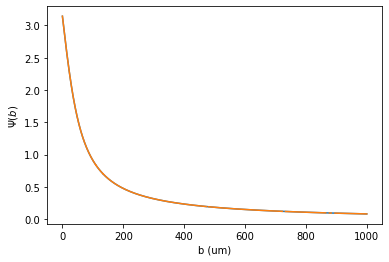

In [57]:
# Thankfully they do agree...
plt.plot(b*hbarc, theta)
plt.plot(b*hbarc, theta_dave)

plt.xlabel('b (um)')
plt.ylabel(r'$\Psi(b)$')

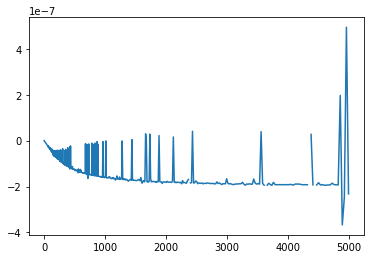

In [58]:
plt.plot(b, theta-theta_dave)

## Differential rate